In [1]:
import mailbox
from datetime import datetime
from datetime import timedelta
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

In [2]:
email_df = pd.read_csv('/srv/zooniverse/tables/emails.csv')
category_df = pd.read_csv('/srv/zooniverse/tables/project_categories_3-12-19.csv')
project_df= pd.read_csv('/srv/zooniverse/tables/all_projects_table_02-18-19.csv')

In [3]:
# only use "official" projects and classifications
project_df = project_df.loc[(project_df['panoptes_api_official_project'] == 1)]

# only include panoptes projects that also have classification data
project_df = project_df.loc[(project_df['panoptes_dump'] == 1) & (project_df['panoptes_api'] == 1)]

# convert email timestamp to datetime
email_df['date'] = pd.to_datetime(email_df['date'])

In [4]:
# get names of projects for which we have email, category, and classification data
overlapping_projects = category_df.loc[(category_df['project_name'].str.lower().isin(project_df['panoptes_project_name'].str.lower())) & (category_df['project_name'].str.lower().isin(email_df['project'].str.lower()))][['project_name']]

In [5]:
# load classification df
classification_df = pd.read_csv('/srv/zooniverse/tables/all_classifications_table_02-18-19.csv')

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# only use "official" projects and classifications
classification_df = classification_df.loc[classification_df['panoptes_api_official_project'] == 1]

# add name column to classification_df
classification_df = classification_df.merge(project_df[['panoptes_project_name','panoptes_project_id']],on='panoptes_project_id')

# online use projects with email, category, and classification data
classification_df = classification_df.loc[classification_df['panoptes_project_name'].str.lower().isin(overlapping_projects['project_name'].str.lower())]

# convert classification timestamp to datetime
classification_df['created_at'] = pd.to_datetime(classification_df['created_at'])

In [12]:
email_df['iso_week'] = email_df['date'].apply(get_weeks)
classification_df['iso_week'] = classification_df['created_at'].apply(get_weeks)

In [7]:
def get_weeks(x):
    return x.isocalendar()[0]*52+x.isocalendar()[1]

def classifications_by_time(classification_df, email_df, title=None):
    classification_df['iso_week'] = classification_df['created_at'].apply(get_weeks)
    #classifications_by_week = classification_df.merge(project_df[['panoptes_project_name','panoptes_project_id']],on='panoptes_project_id',how='left')
    classifications_by_week = classification_df.groupby(['panoptes_project_name','iso_week'])['iso_week'].size().unstack(level=0)
    classifications_by_week.plot(figsize=(12,12))
    
    email_df['iso_week'] = email_df['date'].apply(get_weeks)
    plt.vlines(x=email_df.loc[email_df['iso_week'] < classification_df['iso_week'].max()]['iso_week'].tolist(),
               ymin=0,
               ymax=classifications_by_week.max().max(),
               linestyles='dashed',
               lw=1)
    
    plt.xlabel('ISO Date (Years * 52 + Weeks)')
    plt.ylabel('Number of Classifications')
    plt.tight_layout()
    
    if title:
        plt.title(title)

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


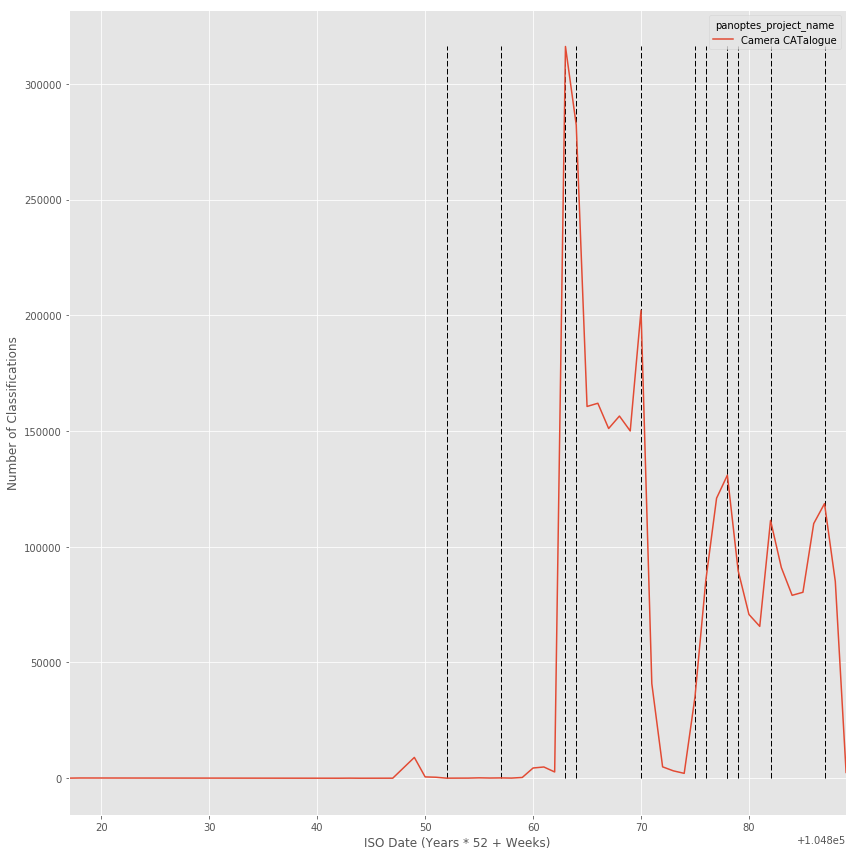

In [113]:
classifications_by_time(classification_df=classification_df.loc[classification_df['panoptes_project_name'] == "Camera CATalogue"]
                        ,email_df=email_df)

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


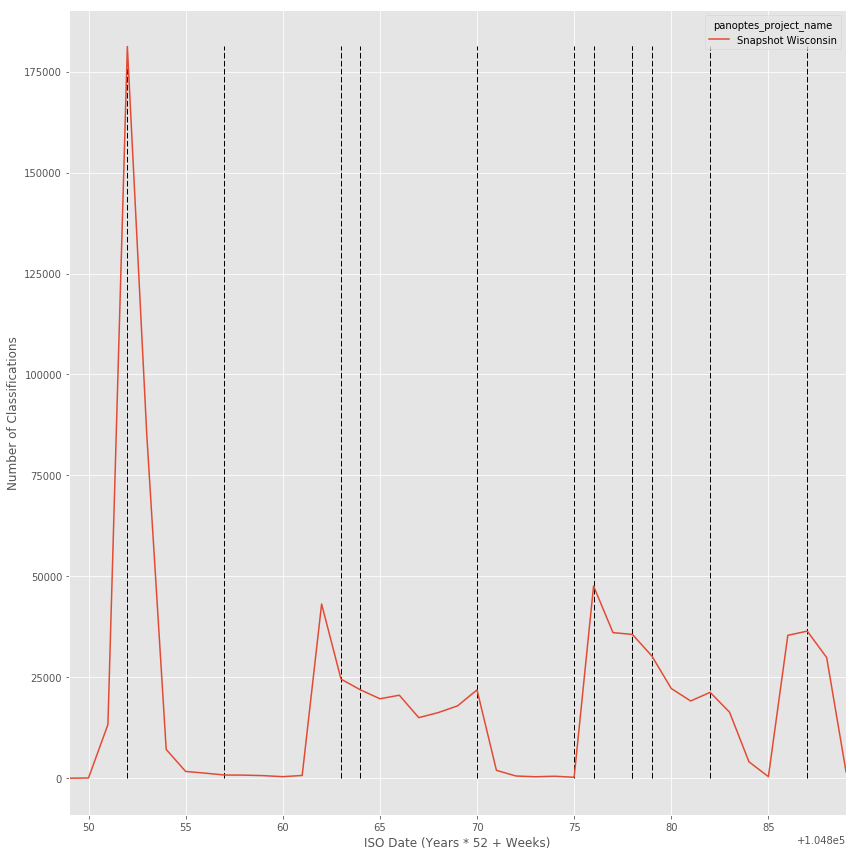

In [116]:
classifications_by_time(classification_df=classification_df.loc[classification_df['panoptes_project_name'] == "Snapshot Wisconsin"]
                        ,email_df=email_df)

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


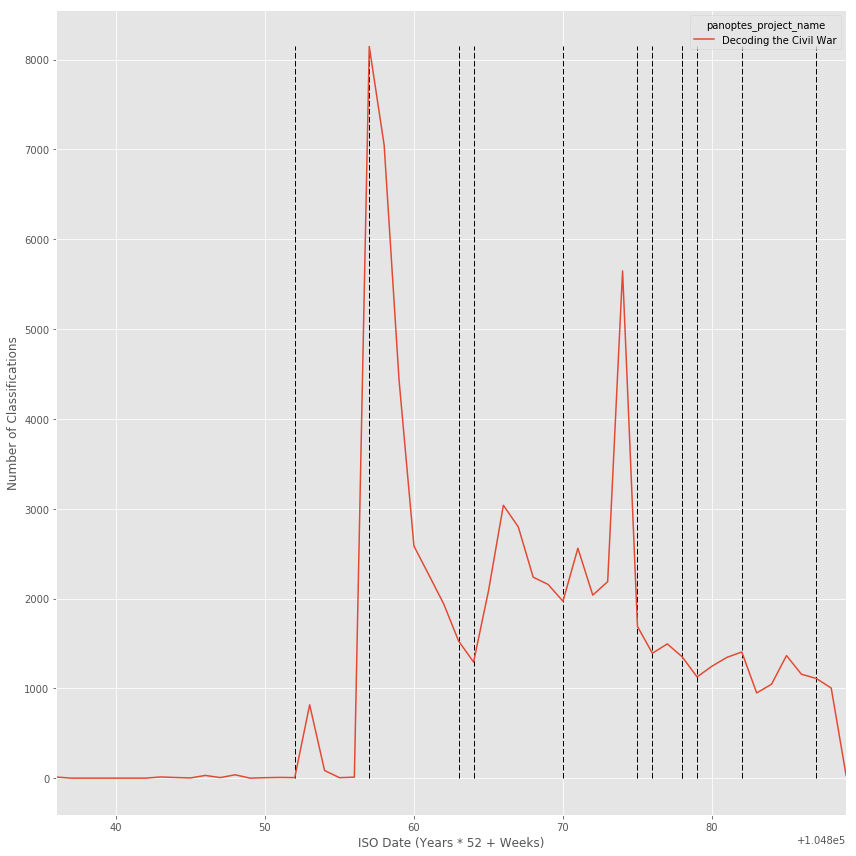

In [117]:
classifications_by_time(classification_df=classification_df.loc[classification_df['panoptes_project_name'] == "Decoding the Civil War"]
                        ,email_df=email_df)

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


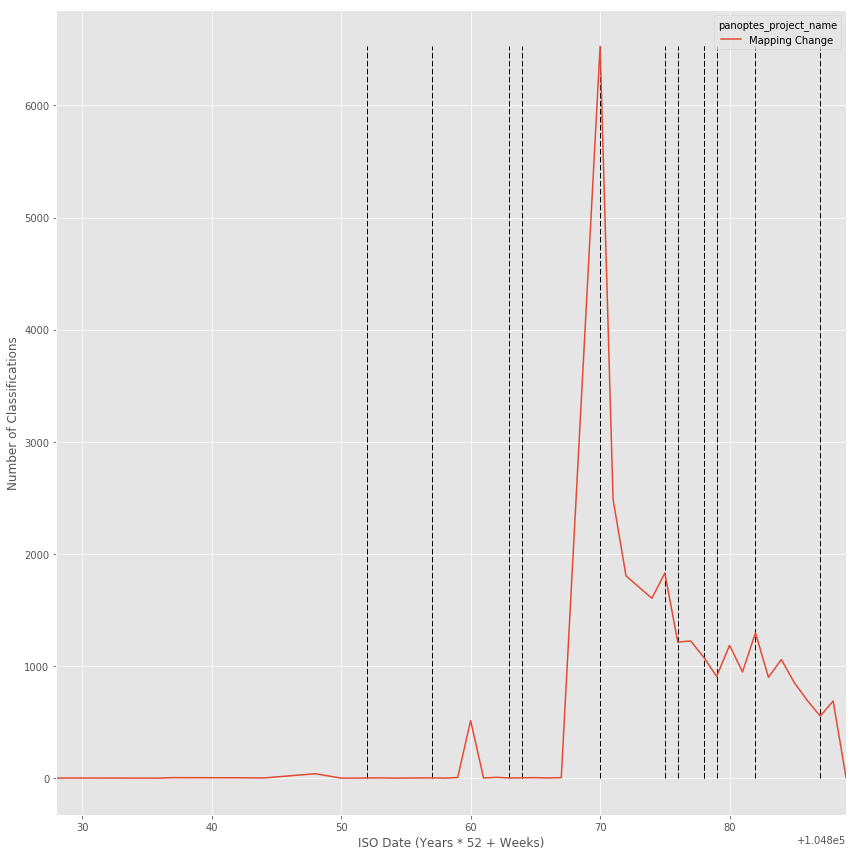

In [8]:
classifications_by_time(classification_df=classification_df.loc[classification_df['panoptes_project_name'] == "Mapping Change"]
                        ,email_df=email_df)

In [15]:
toy_classification_df = classification_df.loc[(classification_df['panoptes_project_name'] == "Decoding the Civil War") | (classification_df['panoptes_project_name'] == "Camera CATalogue") | (classification_df['panoptes_project_name'] == "Snapshot Wisconsin") | (classification_df['panoptes_project_name'] == "Mapping Change")]
toy_classification_df = toy_classification_df.loc[(toy_classification_df['iso_week'] > 104860) & (toy_classification_df['iso_week'] < 104875)]
toy_classification_df['iso_week'] = toy_classification_df['iso_week'].subtract(toy_classification_df['iso_week'].min())

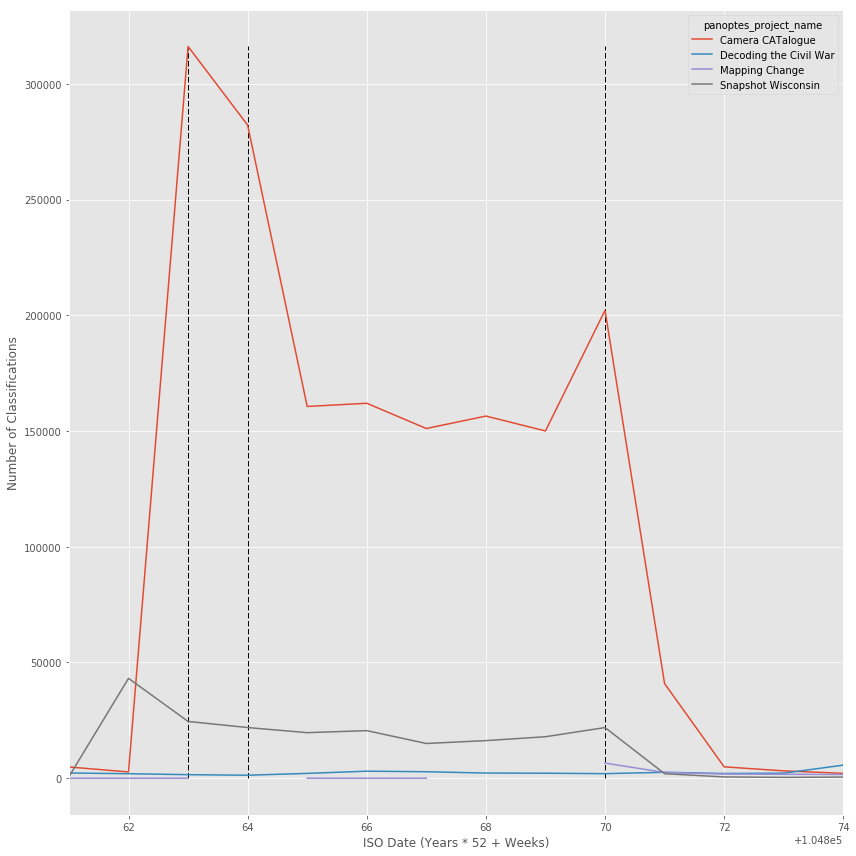

In [16]:
classifications_by_time(toy_classification_df,email_df)

In [20]:
category_df.loc[(category_df['project_name'] == "Decoding the Civil War") | (category_df['project_name'] == "Camera CATalogue") | (category_df['project_name'] == "Snapshot Wisconsin") | (category_df['project_name'] == "Radio Meteor Zoo") | (category_df['project_name'] == "Mapping Change")]

,project_name,categories
44,Mapping Change,"{'Biology', 'Nature', 'Climate'}"
45,Camera CATalogue,"{'Biology', 'Nature'}"
46,Snapshot Wisconsin,"{'Biology', 'Nature'}"
102,Decoding the Civil War,{'History'}
126,Radio Meteor Zoo,{'Physics'}


In [138]:
email_df

,date,timedelta,project,iso_week
0,2016-05-17 10:29:00,130 days 04:13:00.000000000,snapshot wisconsin,104852
1,2016-06-21 11:13:00,35 days 00:44:00.000000000,decoding the civil war,104857
2,2016-08-04 09:14:00,43 days 22:01:00.000000000,camera catalogue,104863
3,2016-08-12 09:07:00,7 days 23:53:00.000000000,radio meteor zoo,104864
4,2016-09-20 09:55:00,39 days 00:48:00.000000000,mapping change,104870
5,2016-10-26 11:34:00,36 days 01:39:00.000000000,NaN,104875
6,2016-11-02 13:46:00,7 days 02:12:00.000000000,focus on wildlife cleveland metroparks,104876
7,2016-11-16 09:14:00,13 days 19:28:00.000000000,toledo zoo wild shots,104878
8,2016-11-16 09:15:00,0 days 00:01:00.000000000,toledo zoo wild shots,104878
9,2016-11-23 11:34:00,7 days 02:19:00.000000000,snow spotter,104879


In [21]:
classifications_by_week = toy_classification_df.groupby(['panoptes_project_name','iso_week'])['iso_week'].size().to_frame('classifications').reset_index()

In [22]:
classifications_by_week

,panoptes_project_name,iso_week,classifications
0,Camera CATalogue,104861,4851
1,Camera CATalogue,104862,2699
2,Camera CATalogue,104863,316143
3,Camera CATalogue,104864,282167
4,Camera CATalogue,104865,160618
5,Camera CATalogue,104866,161999
6,Camera CATalogue,104867,151090
7,Camera CATalogue,104868,156470
8,Camera CATalogue,104869,150035
9,Camera CATalogue,104870,202142


In [157]:
email_df

,date,timedelta,project,iso_week
0,2016-05-17 10:29:00,130 days 04:13:00.000000000,snapshot wisconsin,104852
1,2016-06-21 11:13:00,35 days 00:44:00.000000000,decoding the civil war,104857
2,2016-08-04 09:14:00,43 days 22:01:00.000000000,camera catalogue,104863
3,2016-08-12 09:07:00,7 days 23:53:00.000000000,radio meteor zoo,104864
4,2016-09-20 09:55:00,39 days 00:48:00.000000000,mapping change,104870
5,2016-10-26 11:34:00,36 days 01:39:00.000000000,NaN,104875
6,2016-11-02 13:46:00,7 days 02:12:00.000000000,focus on wildlife cleveland metroparks,104876
7,2016-11-16 09:14:00,13 days 19:28:00.000000000,toledo zoo wild shots,104878
8,2016-11-16 09:15:00,0 days 00:01:00.000000000,toledo zoo wild shots,104878
9,2016-11-23 11:34:00,7 days 02:19:00.000000000,snow spotter,104879
